In [1]:
#!pip install contractions

In [2]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import unicodedata
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
%matplotlib inline

# from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from tensorflow import keras
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D,Dense,MaxPooling1D, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn import metrics

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

warnings.filterwarnings('ignore')
#nltk.download('punkt')
#nltk.download('stopwords')

In [3]:
#!python -m spacy download en_core_web_md
#!python -m spacy link en_core_web_md en --force

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

import os

#os.chdir(workdir_path)

In [5]:
# Carregar as bases de treino e teste
path = '../datasets/'
df = pd.read_csv(path+'tw_pt.csv', usecols=['Text', 'Classificacao'])
df.head()

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


In [6]:
df.Text[0]

'���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ'

In [8]:
df['Text'][20]

'"O governo de Minas Gerais não comentou o assunto. "\n\nhttps://t.co/SNYMRfQ737'

In [7]:
total = len(df)
print('Número de Tweets na base : ', total)

Número de Tweets na base :  8199


## Pré-processamento da base

#### Remover caracteres especiais e transformar os demais em minúsculos

In [9]:
def clean_text(s):
    #if type(s)!=str:
     #return ""
    s = re.sub(r'-', ' ', s)    
    s = re.sub(r'/MG', ' MG ', s)    # substitui ?MG por ' MG '
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s) # remove re-tweet
    s = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove hash tags
    s = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove tweeted at
    special_char_pattern = re.compile(r'([{.(-)!}])')
    pattern = r'[^a-zA-z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\s]' # remove os caracteres especiais mantendo a acentuação em português
    s = re.sub(pattern, '', s)
    s = special_char_pattern.sub(" \\1 ", s)    
    s = re.sub(r"http[s]?://\S+", "", s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub('([0-9]+)', '', s)  # remove numbers
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = re.sub(r'[\r|\n|\r\n]+', ' ', s)
    s = re.sub(' +', ' ', s)
    soup = BeautifulSoup(s, "html.parser")
    s = soup.get_text()
    s = re.sub(r"\s+"," ",s).strip()
    return s
df['Text'] = df['Text'].apply(clean_text).str.lower()

In [10]:
df.head()

,Text,Classificacao
0,catedral de santo antônio governador valadares mg,Neutro
1,governador valadares minas gerais,Neutro
2,governador valadares minas gerais,Neutro
3,,Neutro
4,psol vai questionar aumento de vereadores e pr...,Negativo


#### Verificar valores nulos após a limpeza da base

In [12]:
print('df.Text: ', (df.Text.isna()).sum())
print('df.Classificacao: ',(df.Classificacao.isna()).sum())

df.Text:  0
df.Classificacao:  0


## Análises estatísticas

#### Distribuição de tweets por Classe

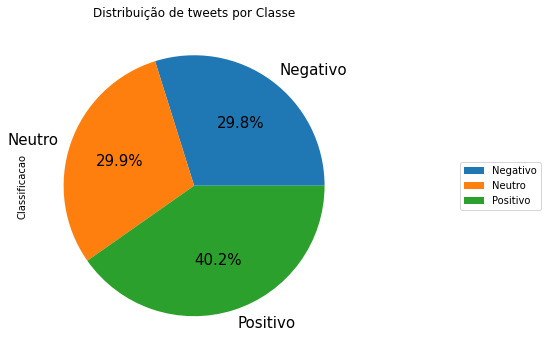

In [13]:
df_distribution = df.Classificacao.value_counts()\
                            .to_frame()\
                            .sort_values('Classificacao')

df_distribution.plot.pie(y='Classificacao', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

#### Tamanho dos tweets por classe

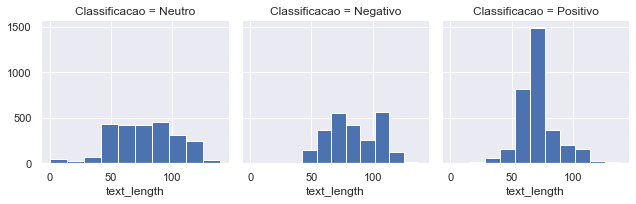

In [14]:
df['text_length'] = df.Text.apply(len)
sns.set(font_scale = 1)
g = sns.FacetGrid(df,col='Classificacao')
g.map(plt.hist,'text_length')
plt.show();

#### Encoding para utilizar 3 classes

In [15]:
encoding = {'Negativo': 'Negativo',
            'Neutro': 'Neutro',
            'Positivo': 'Positivo',
            }

labels = ['Negativo', 'Neutro', 'Positivo']
           
df["Classificacao"].replace(encoding, inplace=True)

#### Quantidade de caracteres nos tweets

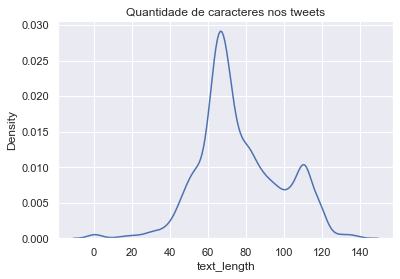

In [16]:
sns.distplot(df.text_length, hist=False)
plt.title('Quantidade de caracteres nos tweets')
plt.show();

#### Distribuição da quantidade de palavras nos tweets

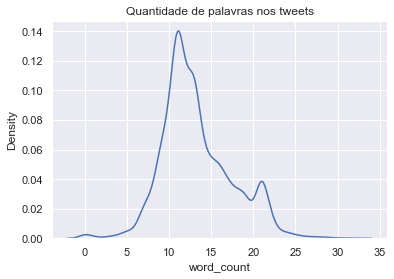

In [17]:
df['word_count'] = df.Text.apply(lambda x: len(str(x).split()))
sns.distplot(df.word_count, hist=False)
plt.title('Quantidade de palavras nos tweets')
plt.show();

## WordCloud

### Unigrams

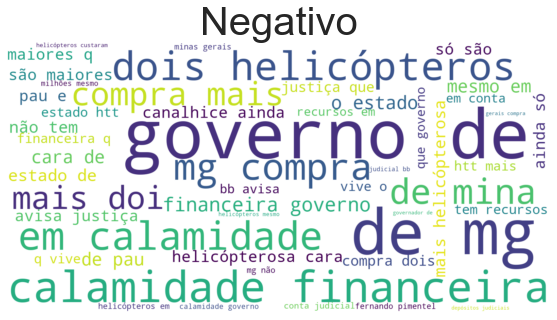

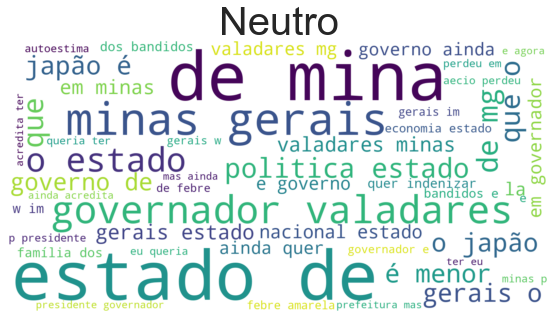

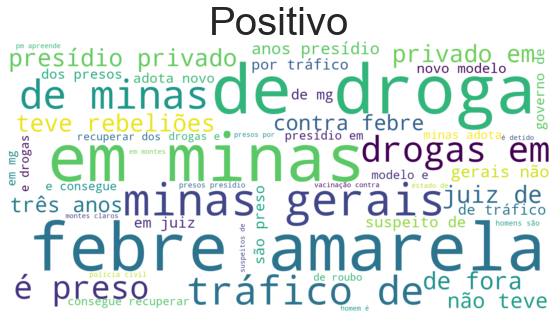

In [18]:
### Converte lista strings em um único texto
labels = np.unique(df.Classificacao)
for label in labels:
    rows = df[df.Classificacao == label]
    corpus = " ".join(text for text in rows.Text)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate(corpus)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

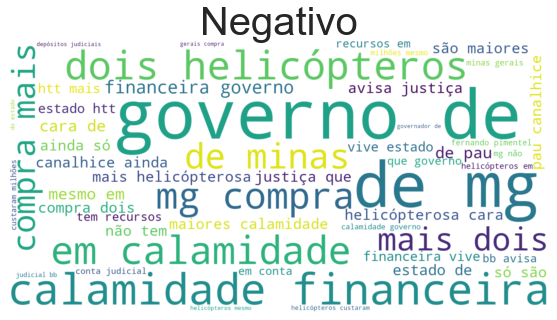

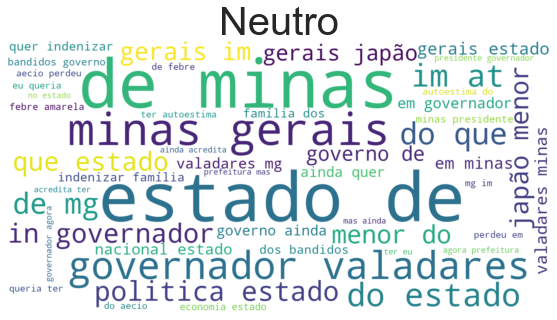

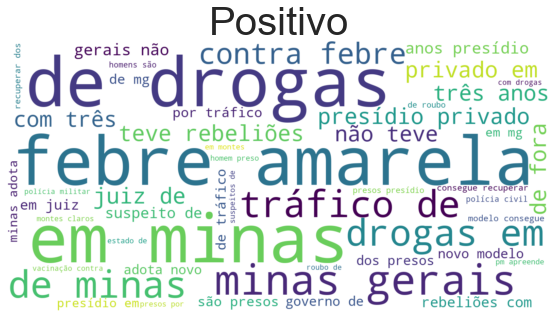

In [19]:
### Converte lista de strings em um único texto
labels = np.unique(df.Classificacao)
corpus = []
for label in labels:
    rows = df[df.Classificacao == label]
    corpus = " ".join(text for text in rows.Text)
    vec = CountVectorizer(ngram_range=(2, 2)).fit([corpus])
    bag_of_words = vec.transform([corpus])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    most_common = dict(words_freq)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

   

### Trigrams

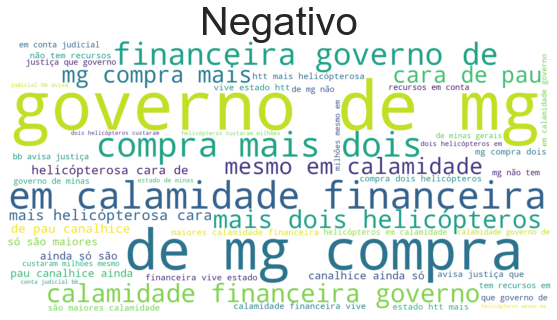

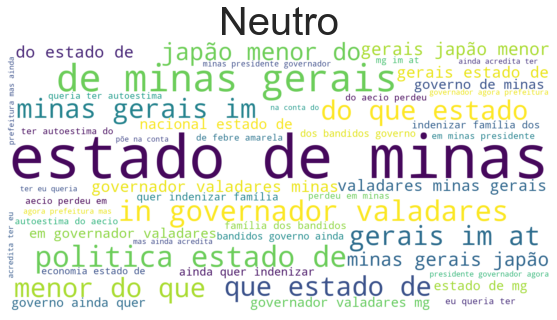

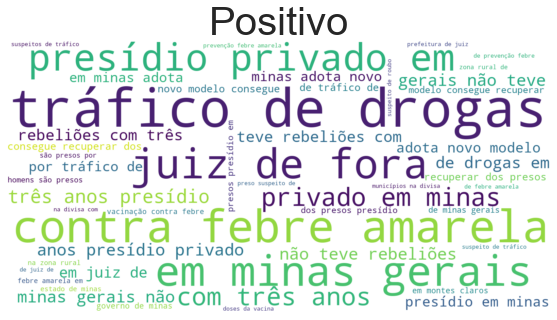

In [20]:
### Converte lista de strings em um único texto
labels = np.unique(df.Classificacao)
corpus = []
for label in labels:
    rows = df[df.Classificacao == label]
    corpus = " ".join(text for text in rows.Text)
    vec = CountVectorizer(ngram_range=(3,3)).fit([corpus])
    bag_of_words = vec.transform([corpus])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    most_common = dict(words_freq)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets - Embedding e CNN-LSTM

#### Dividir a base em dados e labels (X,y)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df['text'] = df.Text
df["text"] = df["text"].astype(str)

X = df['text'].tolist()
y = pd.get_dummies(df['Classificacao']).values
num_classes = df['Classificacao'].nunique()
y
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state =100,
                                                   stratify=y)

#### Variáveis

In [23]:
batch_size = 256
epochs = 30
max_features = 30000 # número máximo de palavras utilizado para o vocabulário (número de "vetores de palavras")
init_lr = 1e-2
seed = 100
num_classes = df['Classificacao'].nunique()

#### Criar os vetores de palavras

In [24]:
max_features = max_features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
max_words = 100 # número máximo de palavras em um comentário
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(6559, 100) (1640, 100)


#### Callbacks

In [26]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose = True, monitor='val_loss', mode='min')
mc = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(patience = 2, verbose = True, factor=0.5, monitor='val_loss', restore_best_weights=True, mode='min')

#### Otimizador

In [27]:
opt = Adam(learning_rate=init_lr)

#### Função para montar a embedding_matrix

In [28]:
from gensim.models import KeyedVectors

In [29]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=max_features):
    # word vectors
   # embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE
   #                                                                          , encoding='utf8'))
    
    model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,limit=100)
    
    embeddings_index = {word: model[word] for word in model.index_to_key}
    
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

#### Função para montar a Rede Neural

In [30]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
           
    model = Sequential()

    ## Camada Embedding
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix], trainable = True))
       

    ## Camadas LSTM
    
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))

    ## Camadas Full Connected - Fazem a classificação
    
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['acc'])
    print(model.summary())
    return model

#### Função para treinar a Rede Neural

In [31]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_split=0.2, 
                          epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[es,rlr,mc])
    # plot train history
    plot_model_history(model_history)

#### Função verificação do Histórico de Treinamento

In [32]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show();

#### Função para avalição da Rede Neural

In [33]:
def model_evaluate(): 
    # predict class with test set
    # y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0) código
    # deprecatede não utiliza mais model.predict_classes
    
    y_pred_test =  model.predict(X_test) # novo formato para fazer a prvisão das classes
    y_pred_test = np.argmax(y_pred_test, axis=1) # converte para array
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
   
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show();

Found 100 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          551800    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 632,503
Trainable params: 632,503
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
21/21 - 13s - loss: 0.2929 - acc: 0.8050 - val_loss: 0.1159 - val_acc: 0.9398

Epoch 00001: val_loss improved from inf to 0.11587, saving model to best_model.h5
Epoch 2/30
21/21 - 10s - loss: 0.0824 - acc: 0.9560 - val_loss: 0.0927 - val_acc: 0.9558

Epoch 00002: val_loss improved from 0.11587 to 0.09273, saving model to best_model.h5
Epo

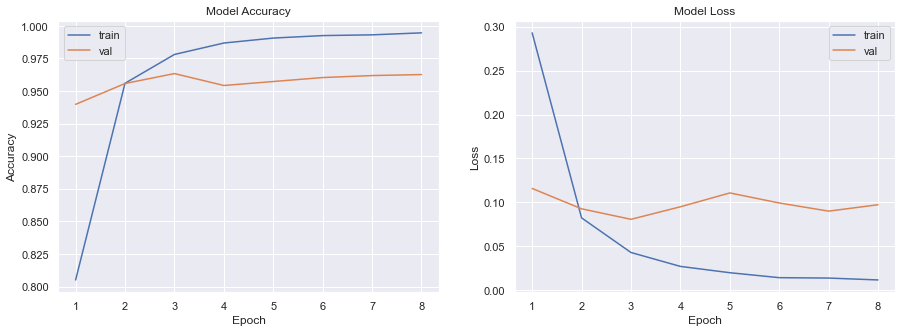

In [34]:
# embedding matrix

EMBEDDING_FILE ='../gloves/glove_s100.txt'
embed_dim = 100 # --> Cada palavra é representada por um vetor de 100 dimensões (glove_s100.txt)
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)



              precision    recall  f1-score   support

           0       0.98      0.95      0.96       489
           1       0.93      0.96      0.95       491
           2       0.98      0.98      0.98       660

    accuracy                           0.96      1640
   macro avg       0.96      0.96      0.96      1640
weighted avg       0.97      0.96      0.96      1640



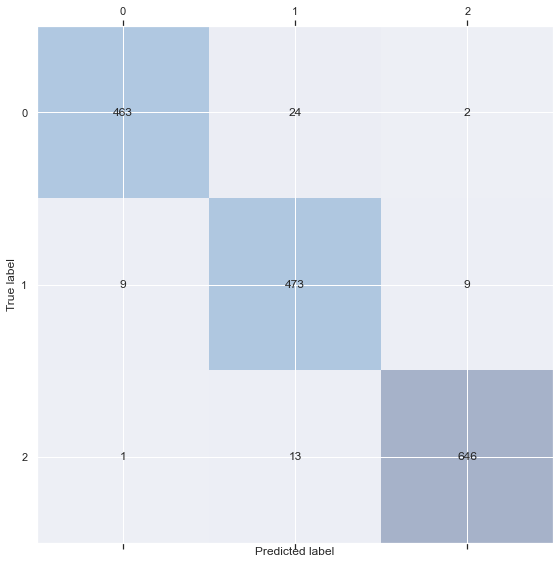

In [35]:
model_evaluate()